In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.7 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd 
import yfinance as yf

There are 1510 observations in the training data
There are 251 observations in the test data


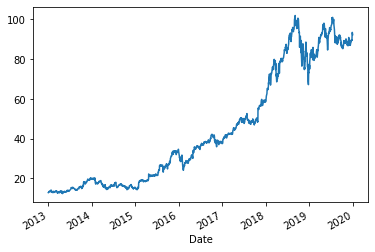

In [3]:
AMZN = yf.download('AMZN', 
                  start = '2013-01-01',
                  end = '2019-12-31',
                  progress = False)

all_data = AMZN[['Adj Close', 'Open', 'High','Low',"Close","Volume"]].round(2)
all_data.head(10)

print("There are "+str(all_data[:'2018'].shape[0])+" observations in the training data")
print("There are "+str(all_data['2019':].shape[0])+" observations in the test data")
all_data['Adj Close'].plot()

In [4]:
all_data.head()

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2013-01-02,12.87,12.80,12.90,12.66,12.87,65420000
2013-01-03,12.92,12.86,13.04,12.82,12.92,55018000
2013-01-04,12.96,12.88,12.99,12.83,12.96,37484000
2013-01-07,13.42,13.15,13.49,13.13,13.42,98200000
2013-01-08,13.32,13.35,13.45,13.18,13.32,60214000


# RNN/LSTM

![RNN/LSTM](https://camo.githubusercontent.com/0e2a1b8be279c013abc74e10697c02f6d09215aeac4bfdb2909686bb18e749c4/68747470733a2f2f696d67312e6461756d63646e2e6e65742f7468756d622f523132383078302f3f73636f64653d6d746973746f72793226666e616d653d6874747073253341253246253246626c6f672e6b616b616f63646e2e6e6574253246646e253246624a66306159253246627471554c394a4465795425324670304d6c45654649596c37536b6252436b44776b5730253246696d672e706e67)

![many2one](https://camo.githubusercontent.com/33f6ae2cfea74079918e5c69b1132ac657a1ed28e9b975d3a8e6f70ae57b35dd/68747470733a2f2f696d67312e6461756d63646e2e6e65742f7468756d622f523132383078302f3f73636f64653d6d746973746f72793226666e616d653d6874747073253341253246253246626c6f672e6b616b616f63646e2e6e6574253246646e25324672546668592532466274715652776858613047253246527857386b7a6352485432486258525a6c4b5032514b253246696d672e706e67)

![feature](https://camo.githubusercontent.com/537102c3be96cf084612f858ef558bf54592bc2f5c6fbf650001156ad87a4c09/68747470733a2f2f312e62702e626c6f6773706f742e636f6d2f2d417335634f475f466174632f584d5238306e656d7647492f41414141414141417164732f5f7851616b50676330756f584d58504476397042392d414a78646a737544574e41434c63424741732f733634302f6e6e2e706e67)

In [5]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test = all_data['2019':].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

In [6]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5,2)
X_train.shape[0], X_train.shape[1]

(1504, 5)

In [7]:
# Convert the 3D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1504 samples in the training data
There are 249 samples in the test data


# LSTM

In [8]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')
    
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

![momentom-nesterov](https://camo.githubusercontent.com/9691ff18c76a5f516648bdc445ba6a4f045d50d1d063b76fb88afa65688707fd/68747470733a2f2f6769746875622e636f6d2f736b7977616c6b65723032332f626c6f675f696d616765732f626c6f622f6d61737465722f6f7074696d697a6174696f6e2f6e65737465726f765f6d6f6d656e74756d2e706e673f7261773d74727565)

In [9]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(4.7655807, <matplotlib.axes._subplots.AxesSubplot at 0x7fbc7a064190>)

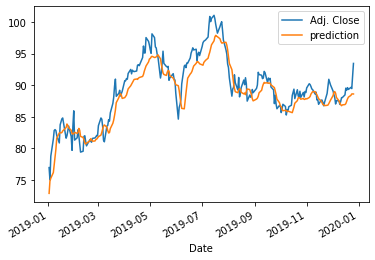

In [10]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [11]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test=all_data.loc['2019':,'Adj Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [13]:
confirm_result(y_test, y_pred)

,Results
MAE,1.74006
RMSE,2.18302
RMSLE,0.02416
R2,0.81480


# GRU

In [14]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(2.7319658, <matplotlib.axes._subplots.AxesSubplot at 0x7fbc76aea550>)

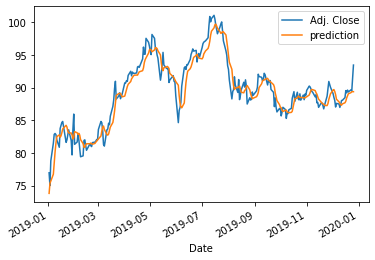

In [15]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [16]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=all_data.loc['2019':,'Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [17]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,1.26906
RMSE,1.65287
RMSLE,0.01850
R2,0.89383
